# Исследование данных о продаже игр

**Цель исследования:** необходимо выявить закономерности, определяющие успешность игры. 

**Входные данные:** исторические данные о продажах игр из открытых источников, оценки пользователей и экспертов, жанры и платформы.

**План работы:** 1. изучить общую информацию о предоставленных данных; 2. подготовить данные, т.е. выявить и удалить (заменить) пропущенные значения и дубликаты, изменить тип данных при необходимости; 3. провести исследовательский анализ данных; 4. составить портрет пользователя каждого региона; 5. проверить гипотезы.

Данное исследование позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Открываем файл с данными и изучаем общую информацию 

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from scipy import stats as st

In [2]:
# Загружаем файл с данными
try: data = pd.read_csv('C:/Users/user/Downloads/games.csv', sep=',')
except: data = pd.read_csv('/datasets/games.csv', sep=',')
pd.set_option('display.max_columns', None)    

In [3]:
# Смотрим общую информацию 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод**

Из полученных данных, видим, что всего строк 16715, но в части столбцов присутствую пропуски, рассмотрим отдельно эти столбцы и решим, удалять строки с пропусками или заменить пропуски. Названия столбцов, для удобства, приведем к нижнему регистру. Проверим данные на дубликаты.

### Предобработка данных

In [4]:
# Приводим названия всех столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
# Проверяем данные на дубликаты
if data.duplicated().sum() > 0:
    print('Дубликатов: ', data.duplicated().sum())
else:
    print('Дубликаты отсутствуют')

Дубликаты отсутствуют


In [6]:
# Изменим тип данных
data[['year_of_release','critic_score']] = data[['year_of_release', 'critic_score']].astype('Int64')

<dd> Преобразуем данные в столбцах:<dd> 
<dd> year_of_release - для сортировки и подсчета данных по году выпуска.<dd> 
<dd> critic_score - для сортировки и подсчета данных по оценке критиков.<dd> 

In [7]:
# Посчитаем пропуски
data.isna().mean()*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

Удалим строки с пропущенными значениями в столбцах name и year_of_release, т.к. их менее 2 % от общего количества. Здесь пропуски, возможно, из-за человеческого фактора, не было данных на момент заполнения. 

Пропуски в столбцах critic_score, user_score, rating возможно из-за того, что это игры, вышедшие более 20 лет назад, когда оценки еще не присваивались. Либо непопулярные или же недавно вышедшие и не успевшие набрать оценки. Оставляем как есть данные в столбцах critic_score, user_score, если удалим потеряем большой объем данных, что исказит результаты.

В столбце rating заменим пропуски на явно аномальное значение, т.е. 'unknown', для того, чтобы в последующем, при использовании столбца провести фильтрацию по этому значению (все, кроме него).

In [8]:
# Удаляем пропуски в столбцах name и year_of_release
data = data.dropna(subset = ['name', 'year_of_release'])
data.isna().mean()*100

name                0.000000
platform            0.000000
year_of_release     0.000000
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.453418
user_score         40.166626
rating             40.598395
dtype: float64

In [9]:
# Заменим пропуски в столбце rating на значение 'unknown'
data['rating'] = data['rating'].fillna('unknown')

In [10]:
# Посмотри какие есть значения в столбце user_score
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Из всех значений выделяется 'tbd' - это аббревиатура, которая означает, что значение подлежит определению, т.е. еще нет данных для присвоения оценки. Заменим на nan, а не на 0, чтобы при исследовании это не повлияло на результат. Изменим тип на float.

In [11]:
# Заменим значение 'tbd' на nan
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')

In [12]:
# Посчитаем общую сумму продаж по всем регионам для каждой игры и добавим столбец с этими данными
data['sales_sum'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,unknown,31.38


In [13]:
# Посмотрим, что осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   Int64  
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  sales_sum        16444 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

**Вывод**
<dd>После предобработки данных, удалили небольшой объем данных, который не повлияет на исследование, т.к. составляет менее 2% от общего объема. Остальные пропуски не удалось изменить в силу того, что возможно этих оценок еще в принципе нет, но удалить строки мы не можем, уйдет половина датафрейма.

### Проводим исследовательский анализ данных

In [14]:
# Посчитаем количество игр выпущенных в разные годы
data.pivot_table(index='year_of_release', values='name', aggfunc='count')

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


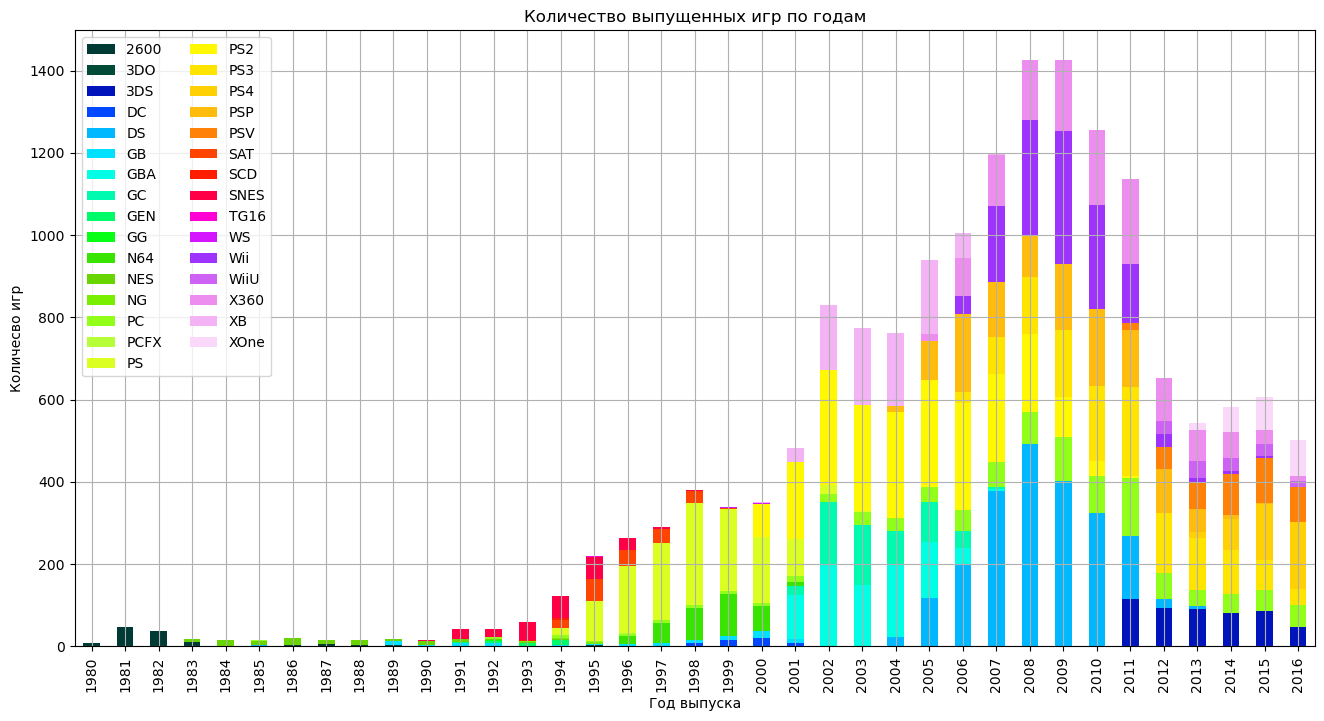

In [15]:
# Построим гистограмму количества игр выпущенных в разные годы, для наглядности
data.pivot_table(
    index='year_of_release', columns='platform',
    values='name', aggfunc='count') \
    .plot(kind='bar', stacked=True, figsize=(16, 8),
          grid=True, color=sns.color_palette("gist_ncar", 31))
plt.legend(bbox_to_anchor=[0, 1], loc='upper left', ncol=2)
plt.title('Количество выпущенных игр по годам')
plt.ylabel("Количесво игр")
plt.xlabel("Год выпуска")
plt.show()

По гистограмме видно, что развитие игр более интенсивно началось с 1995 года. Пик роста был в 2008-2009 гг., начиная с 2010 года пошло снижение. Думаю, что здесь важны не все периоды, более интересны для нас 2010-2016 гг., в котором можно отследить какие игры вышли и набирают популярность или не стали интересны. 

In [16]:
# Выберем 10 платформ с наибольшими суммарными продажами
data_top = (data.pivot_table(index='platform', values='sales_sum', aggfunc='sum')
    .sort_values(by='sales_sum', ascending = False).head(10)
)
data_top

,sales_sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


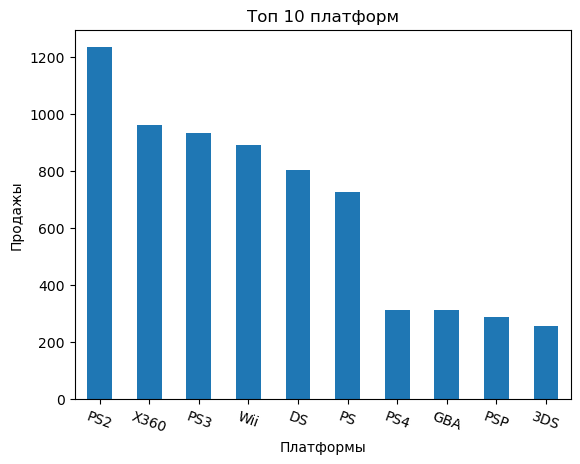

In [17]:
# Построим гистограмму топ 10 платформ с наибольшими суммарными продажами
data_top['sales_sum'].plot.bar(rot = -20);
plt.title('Топ 10 платформ');
plt.ylabel("Продажы");
plt.xlabel("Платформы");

Наиболее популярные и продаваемые PS2, X360, PS3, Wii, DS, PS их и возьмем для дальнейшего исследования.

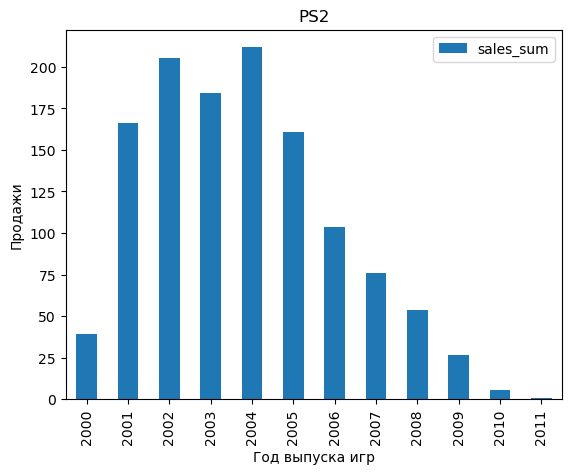

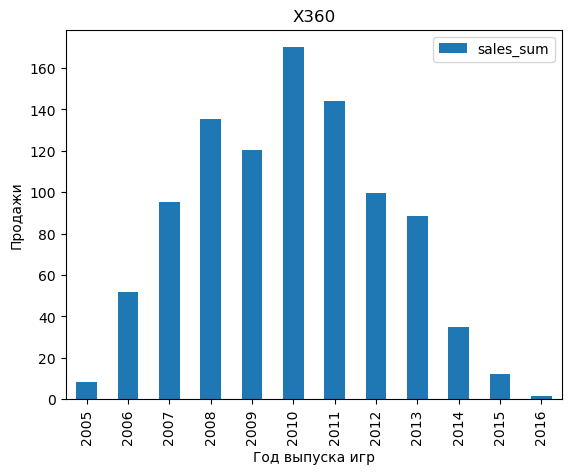

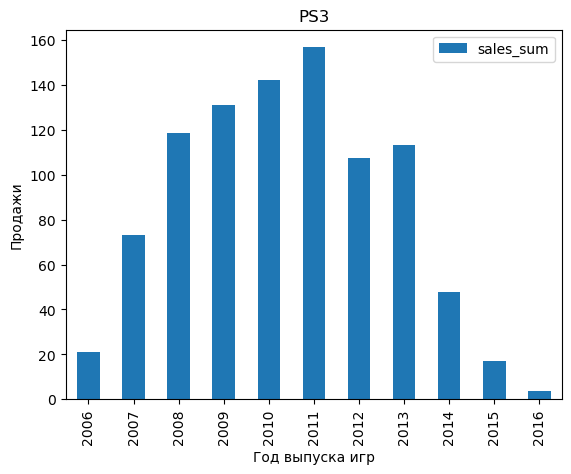

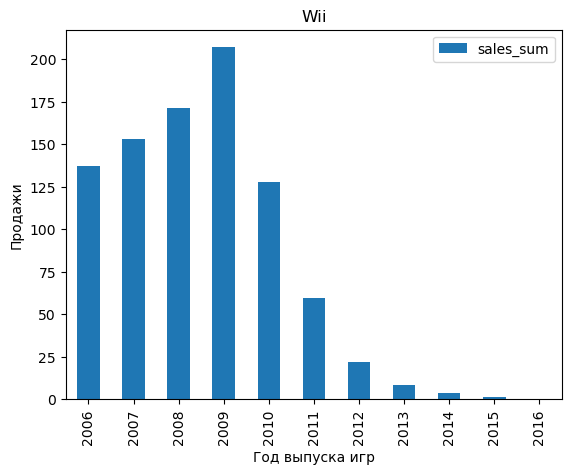

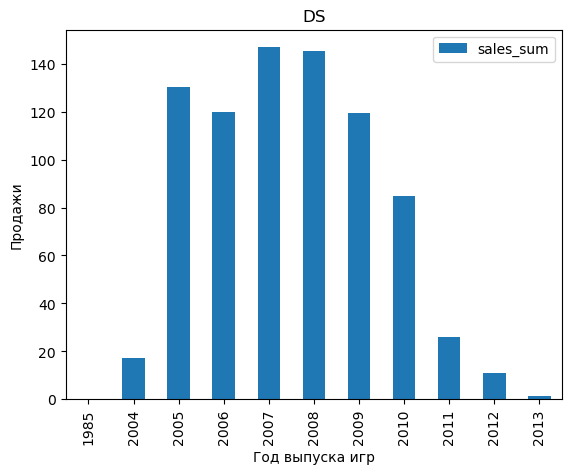

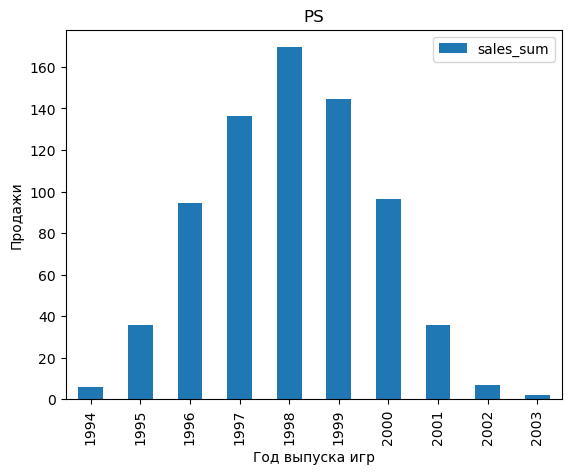

In [18]:
# Построим гистограммы по отдельности для каждой платформы
for platform in data_top.index[:6]:
    (data
.query('platform == @platform')
.pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum')
.plot(kind='bar')
)
    plt.title(platform) 
    plt.ylabel("Продажи");
    plt.xlabel("Год выпуска игр");

**Вывод**
<dd>Период "жизни" новой платформы 10-12 лет, в течении которых они быстро набирают популярность, удерживают ее в течение 5-6 лет, а затем продажи снижаются. 
При этом видно, все рассматриваемые платформы уже не являются актуальными. 

Для целей прогнозирования продаж на следующий год в такой динамично меняющейся индустрии, как компьютерные игры не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Думаю, для исследования лучше взять последние 3 года с 2014 по 2016 гг., этот период и будет актуальным для нас.

Период активных продаж наиболее популярных платформ:
<dd>PS2 - 2001-2005
<dd>X360 - 2008-2011
<dd>PS3 - 2008-2011
<dd>Wii - 2006-2009 
<dd>DS - 2005-2009 
<dd>PS - 1996-1999

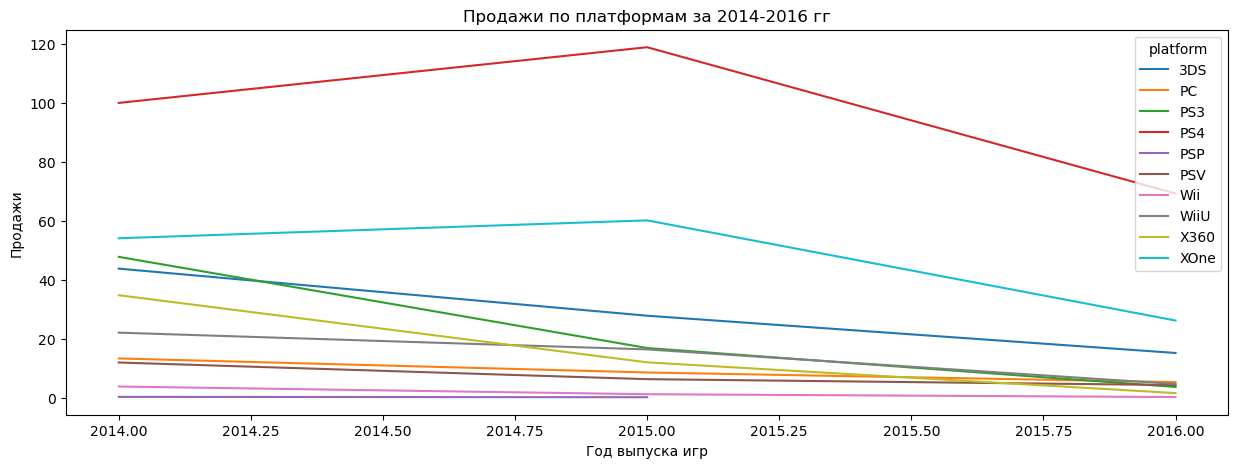

In [19]:
# Построим график продаж по платформам за интересующий нас период 2014-2016 гг.
try: data_act = data.query('year_of_release >= 2014')
except: data_act = data[data['year_of_release'] >= 2014]
data_act.pivot_table(index='year_of_release', columns='platform', values='sales_sum', aggfunc='sum').plot(figsize=(15, 5));
plt.title('Продажи по платформам за 2014-2016 гг')
plt.ylabel("Продажи")
plt.xlabel("Год выпуска игр");

Все платформы падают в продажах к 2016 году, но, если учитывать, что данные за 2016г. не полные, то эта ситуация может измениться для некоторых платформ, которые могут стать потенциально прибыльными: PS4, XOne.

In [20]:
# Выберем платформы с наибольшими суммарными продажами
data_top = (data_act.pivot_table(index='platform', values='sales_sum', aggfunc='sum')
    .sort_values(by='sales_sum', ascending = False).head(6)
)            
data_top

,sales_sum
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98


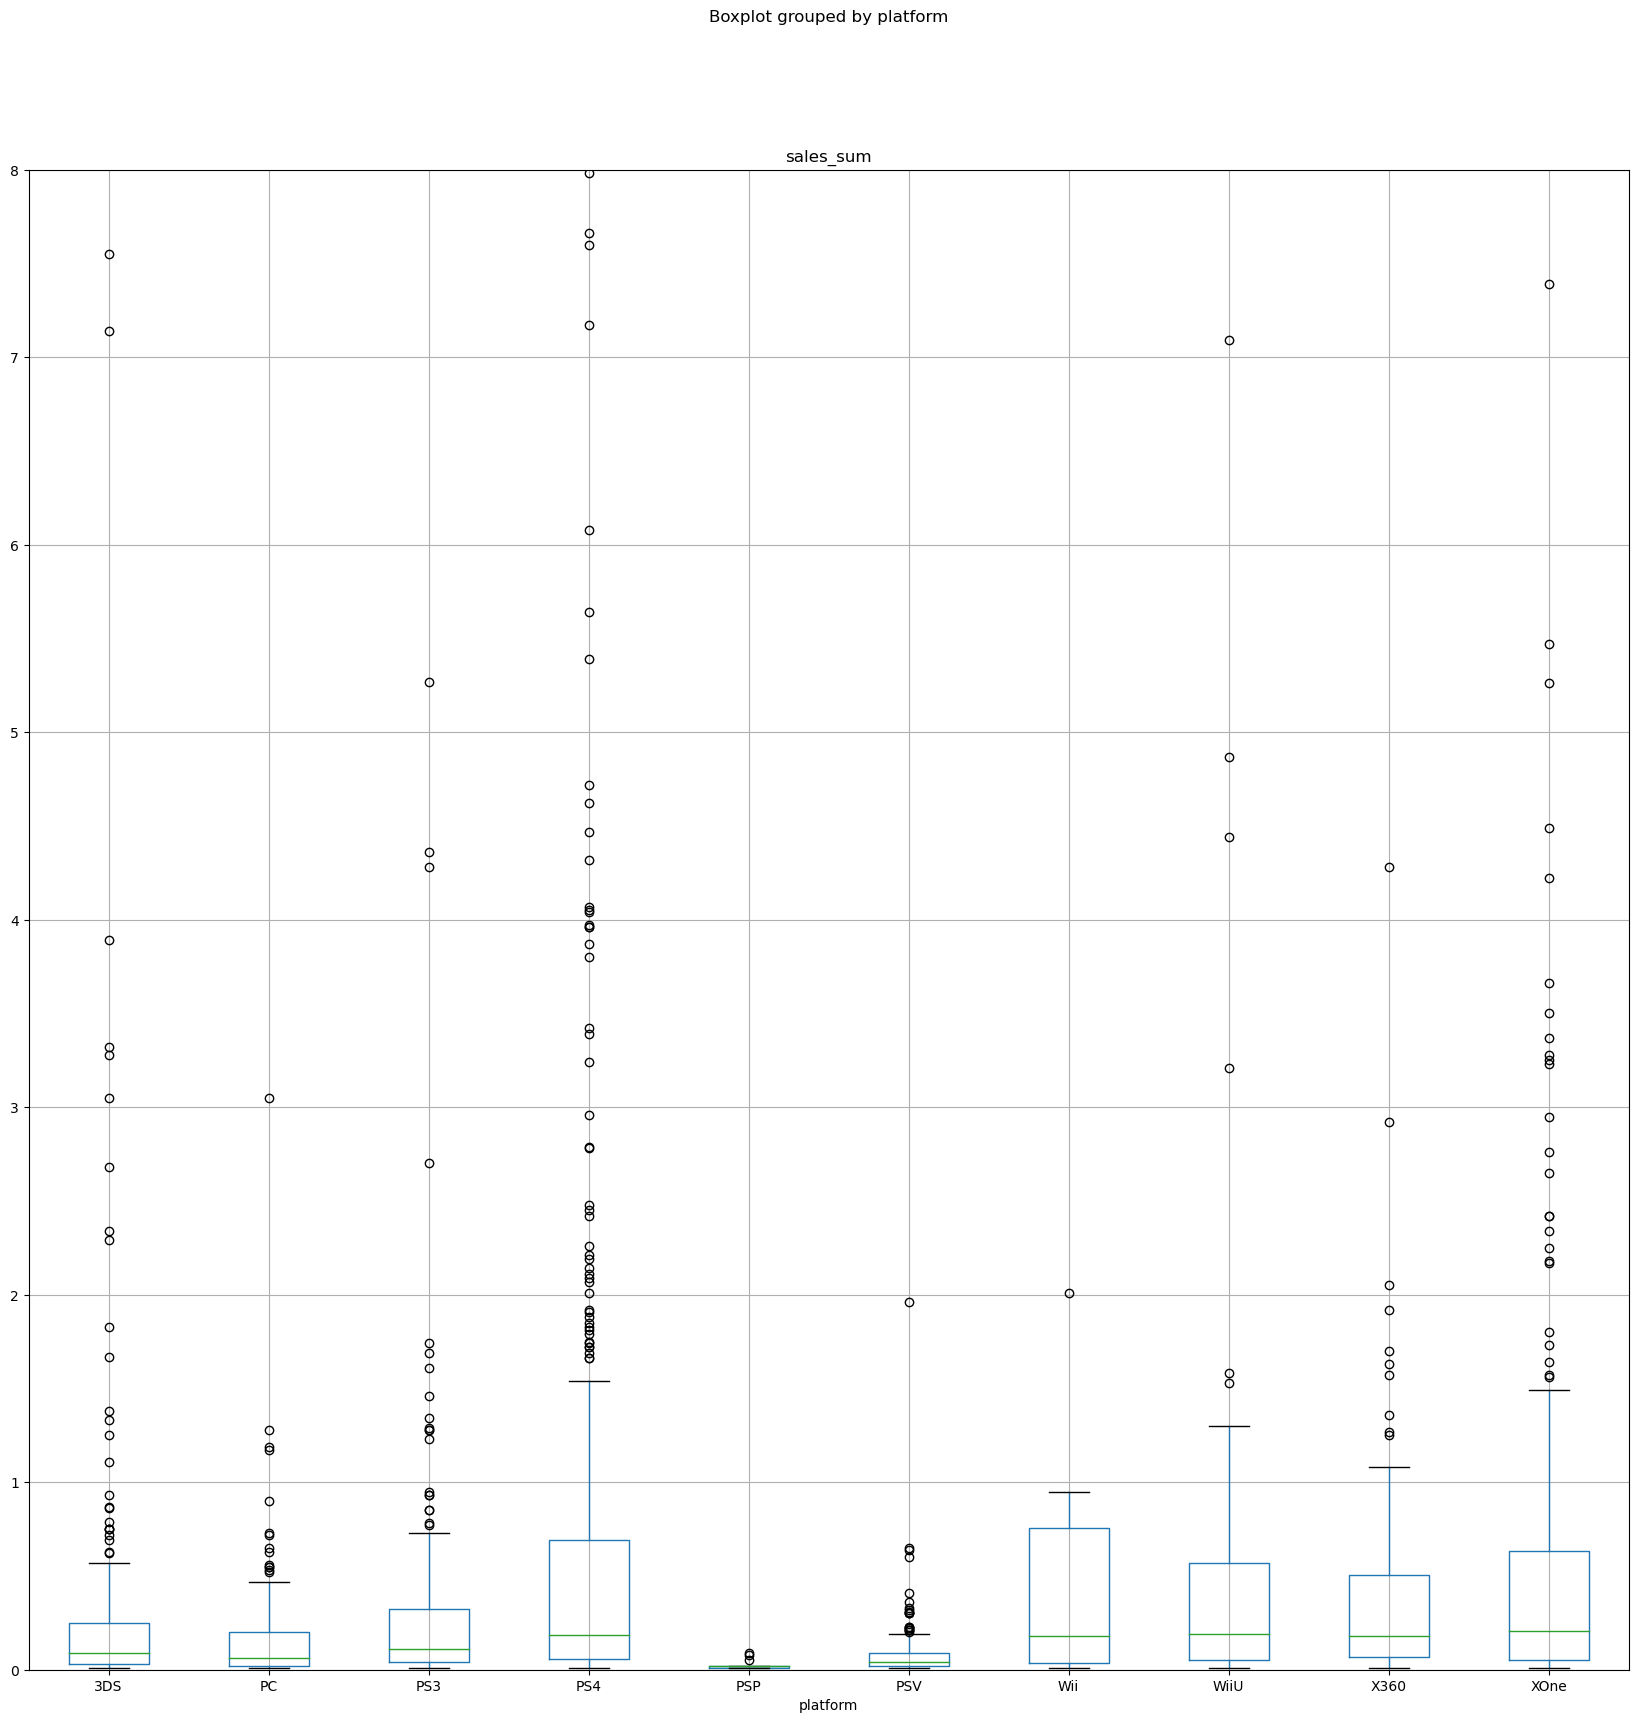

In [21]:
# Постоим "Ящик с усами" для платформ
data_act.boxplot(column='sales_sum', by='platform', figsize=(20,20))
plt.ylim(0,8)
plt.show()

**Вывод**
<dd>По "ящику с усами" можно отметить еще одну платформу WiiU, у которой медианное значение практически совпадает с медианными значениями потенциально прибыльных платформ PS4, XOne, поэтому думаю ее тоже можно отнести к потенциально прибыльной, если еще учитывать, что она вышла в 2011 г., есть вероятность, что продажи возрастут. Платформ Wii тоже близка к этим показателям, но продажи у нее к 2016г падают в отличии от WiiU, у которой продажи хоть и не большие, но стабильные. 

**Корреляция между отзывами и продажами**

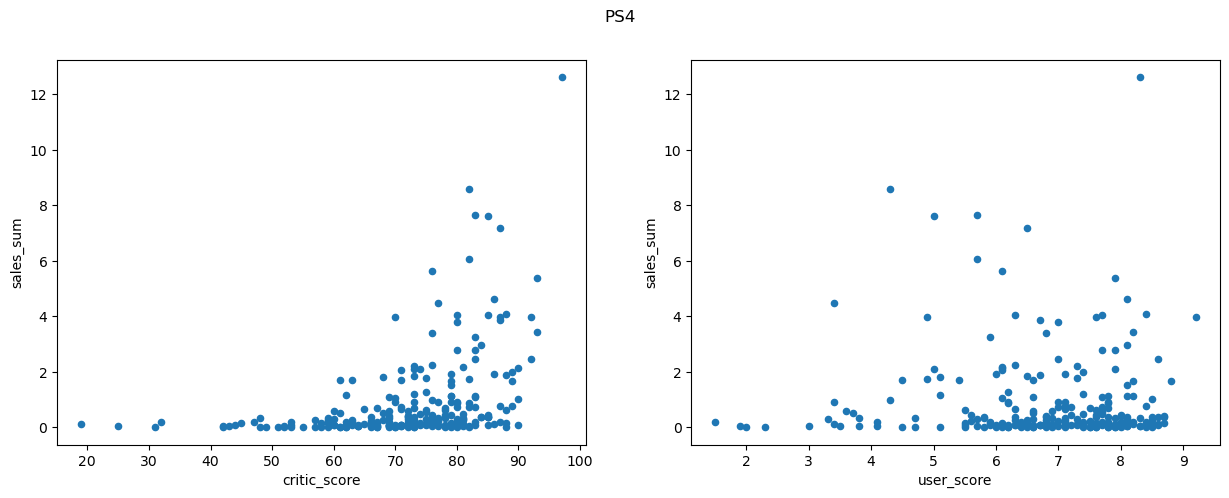

In [22]:
# Постоим диаграмму рассеивания между отзывами и продажами для платформы PS4
for pl in  ['PS4']:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    ax = ax.ravel()
    data_act.query('platform == @pl').plot (kind='scatter', x='critic_score', y='sales_sum', ax = ax[0])
    data_act.query ('user_score != "tbd" and platform == @pl').plot (kind ='scatter', x='user_score', y='sales_sum', ax = ax[1])
    fig.suptitle (pl)

In [23]:
# Рассчитаем коэффициент корреляции для платформы PS4
PS4 = data_act.query('platform == "PS4"')
PS4[['critic_score', 'user_score', 'sales_sum']].corr()

,critic_score,user_score,sales_sum
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
sales_sum,0.402661,-0.040132,1.000000


**Вывод**

Отзывы пользователей никак не влияют на продажи игр, в то время как отзывы критиков слабо, но влияют на продажы: коэффициенты корреляции -0,04 и 0,40 соответственно.

**Соотнесем выводы с продажами игр на платформах XOne, 3DS, PS3**

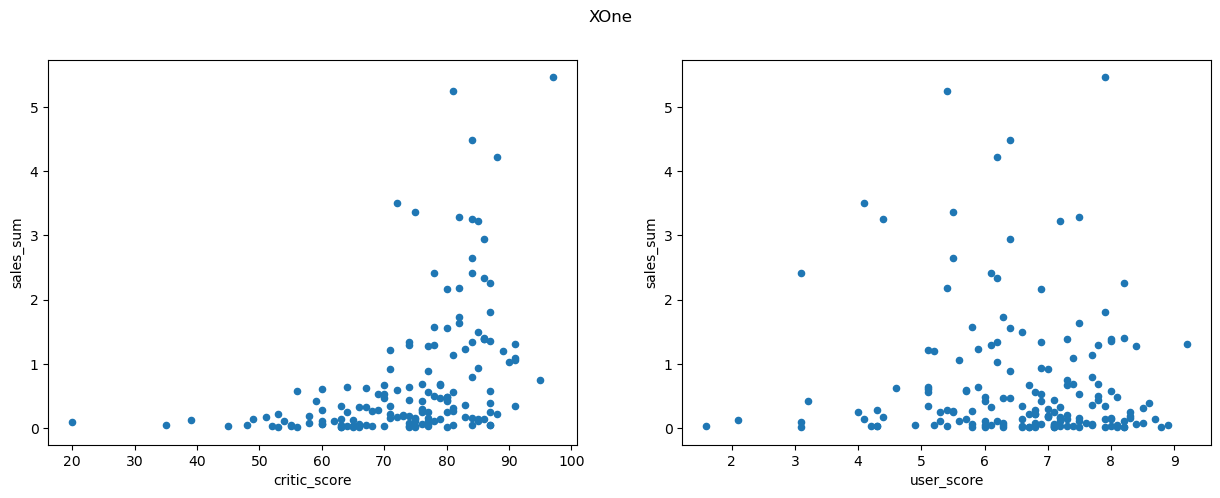

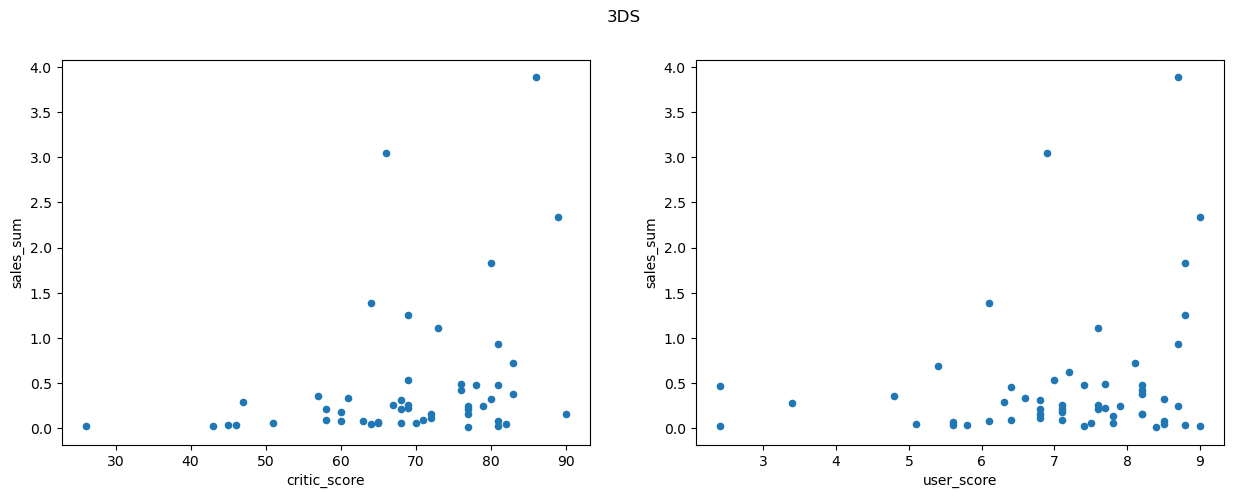

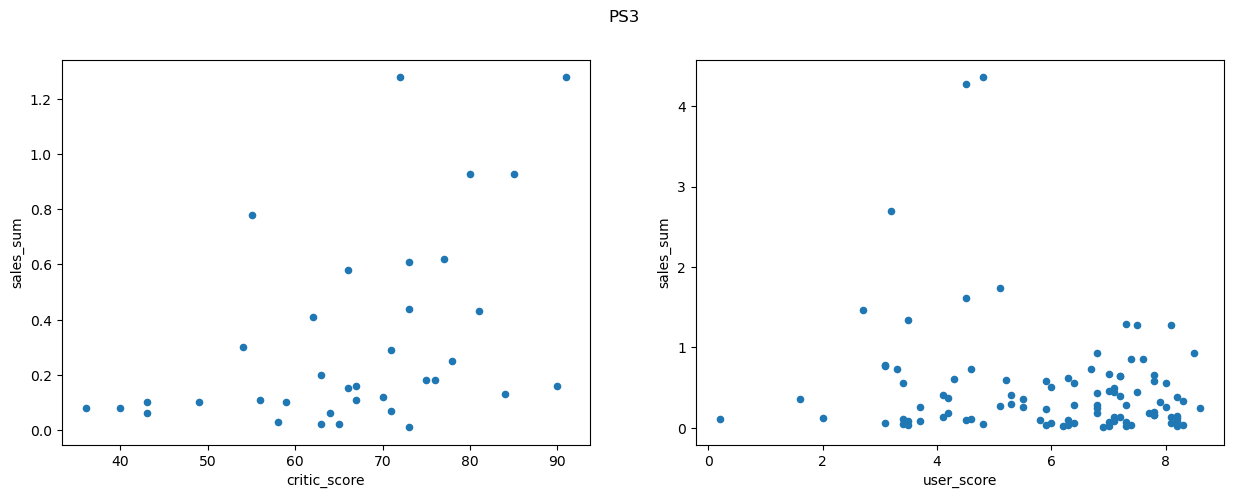

In [24]:
# Постоим диаграмму рассеивания между отзывами и продажами для платформ  XOne, 3DS, PS3
for pl in  ['XOne', '3DS', 'PS3']:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    ax = ax.ravel()
    data_act.query('platform == @pl').plot(kind='scatter', x='critic_score', y='sales_sum', ax = ax[0])
    data_act.query ('user_score != "tbd" and platform == @pl').plot (kind ='scatter', x='user_score', y='sales_sum', ax = ax[1])
    fig.suptitle(pl)

In [25]:
# Рассчитаем коэффициент корреляции для платформ XOne, 3DS, PS3
for pl in  ['XOne', '3DS', 'PS3']:
    row = data_act.query('user_score != "tbd" and platform == @pl')
    row = row[['critic_score', 'user_score', 'sales_sum']].corr()
    print('Коэффициенты корреляции:', pl)
    print(row)

Коэффициенты корреляции: XOne
              critic_score  user_score  sales_sum
critic_score      1.000000    0.440977   0.428677
user_score        0.440977    1.000000  -0.070384
sales_sum         0.428677   -0.070384   1.000000
Коэффициенты корреляции: 3DS
              critic_score  user_score  sales_sum
critic_score      1.000000    0.862485   0.314117
user_score        0.862485    1.000000   0.215193
sales_sum         0.314117    0.215193   1.000000
Коэффициенты корреляции: PS3
              critic_score  user_score  sales_sum
critic_score      1.000000    0.693445   0.446575
user_score        0.693445    1.000000  -0.166761
sales_sum         0.446575   -0.166761   1.000000


**Вывод**

На других платформах та же картина, слабая связь коэффициентов корреляции оценки критиков и очень слабая оценки пользователей.

**Распределение игр по жанрам**

In [26]:
# Посмотрим на топ 5 жанров игр
genre_top5 = (data_act.pivot_table(index='genre', values='sales_sum', aggfunc='median')
    .sort_values(ascending=False, by='sales_sum').head()
)
genre_top5

,sales_sum
genre,
Shooter,0.515
Sports,0.180
Platform,0.140
Fighting,0.125
Role-Playing,0.110


In [27]:
# Объеденим все жанры, кроме топ 5, в группу 'Other'
genre_top = (data_act.pivot_table(index='genre', values='sales_sum', aggfunc='median')
    .sort_values(ascending=False, by='sales_sum')
)
genre_top5.loc['Other', 'sales_sum'] = genre_top.iloc[5:].sum()[0]

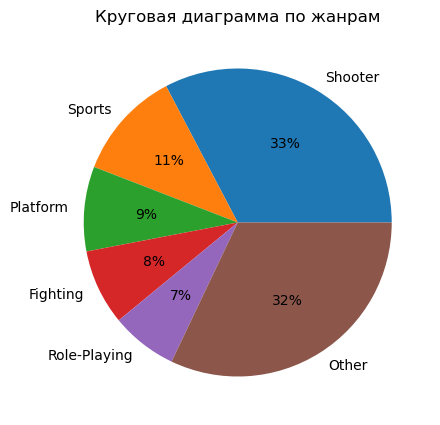

In [45]:
# Построим круговую диаграмму по жанрам
genre_top5.plot(title = 'Круговая диаграмма по жанрам', kind='pie', y='sales_sum', legend=False, figsize=(12,5), autopct='%.0f%%');
plt.ylabel('');

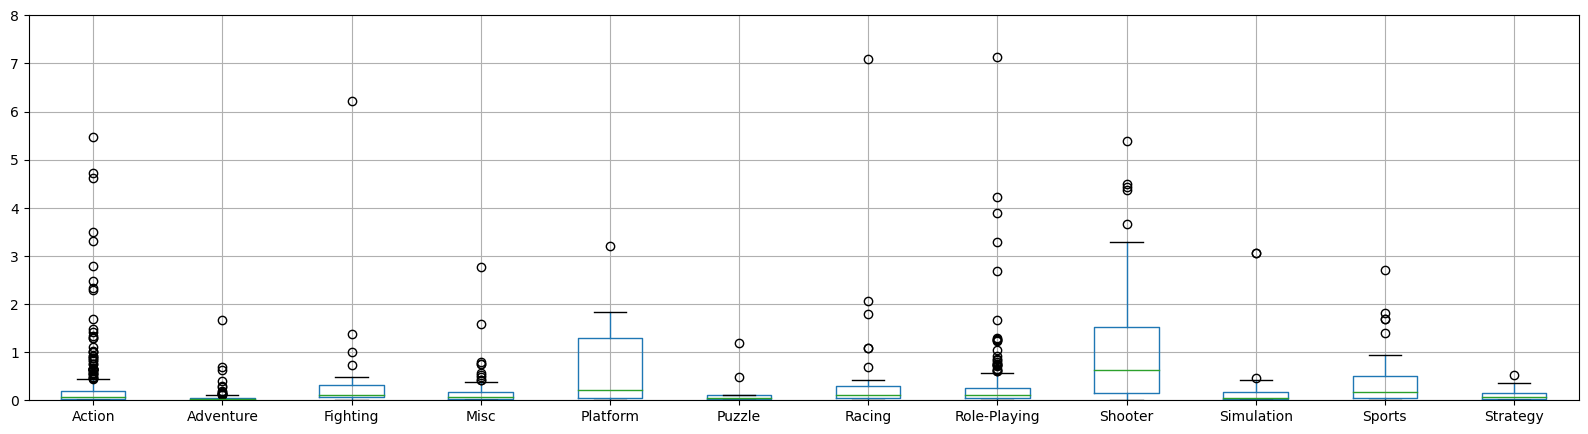

In [29]:
# Построим "Ящик с усами" для платформ
genre_median_act = (data_act.pivot_table(index='name', columns='genre', values='sales_sum', aggfunc='median')
.boxplot(figsize=(20,5))
);
plt.ylim(0,8)
plt.show()

**Вывод**

По круговой диаграмме видим, что самые популярные жанры это Shooter, Sports, Platform, а после сравнение медианных продаж, можно сказать, что эти жанры и более прибыльные, значит стоит сделать ставку на эти жанры. Наименее прибыльные жанры  Strategy, Puzzle, Adventure.

### Составляем портрет пользователя каждого региона

**Самые популярные платформы**

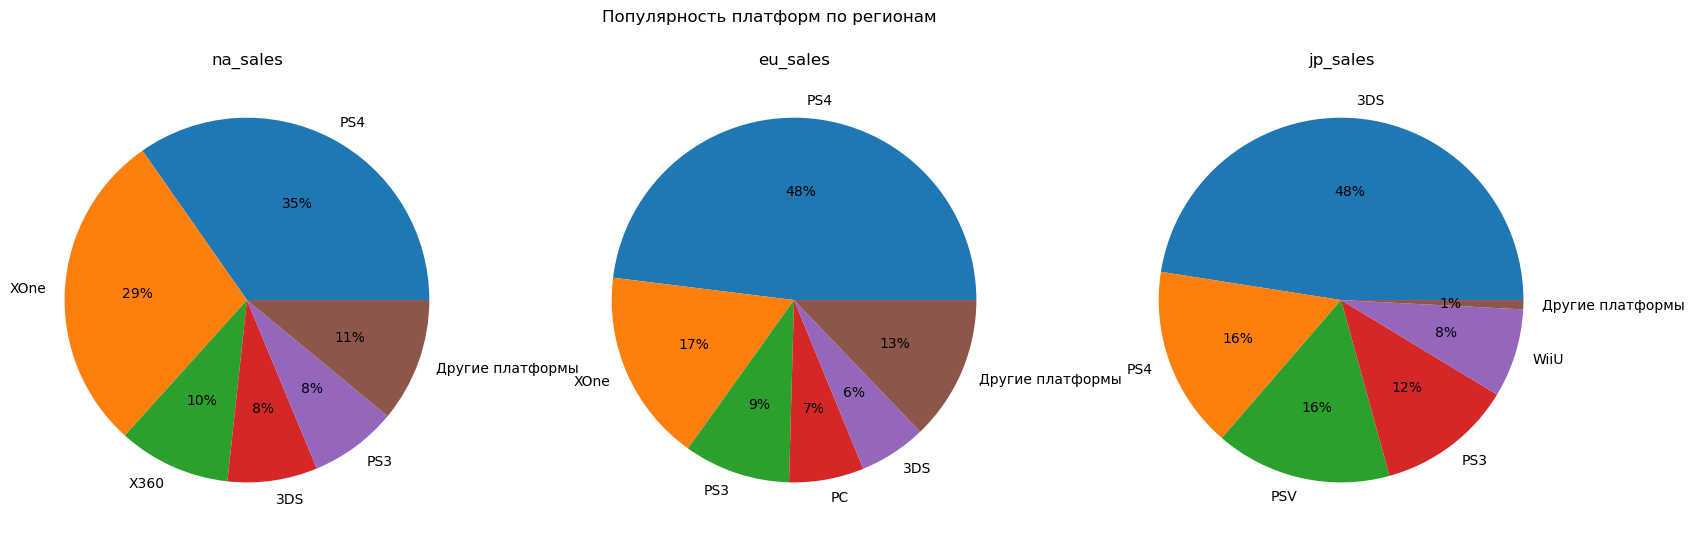

In [48]:
# Построим круговую диаграмму по платформам для каждого региона
genre_na = (data_act.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
.sort_values(by = 'na_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')
.sort_values(by ='na_sales', ascending = False).iloc[5:].sum()[0])
genre_na.loc[5] = ['Другие платформы', sum_p]
genre_na


genre_eu = (data_act.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')\
.sort_values(by = 'eu_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')
.sort_values(by ='eu_sales', ascending = False).iloc[5:].sum()[0])
genre_eu.loc[5] = ['Другие платформы', sum_p]
genre_eu


genre_jp = (data_act.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
.sort_values(by = 'jp_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')
.sort_values(by ='jp_sales', ascending = False).iloc[5:].sum()[0])
genre_jp.loc[5] = ['Другие платформы', sum_p]
genre_jp


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6));
fig.suptitle('Популярность платформ по регионам');
ax1.pie(genre_na['na_sales'], labels=genre_na['platform'],autopct='%1.0f%%');
ax1.set_title('na_sales');
ax2.pie(genre_eu['eu_sales'], labels=genre_eu['platform'],autopct='%1.0f%%');
ax2.set_title('eu_sales');
ax3.pie(genre_jp['jp_sales'], labels=genre_jp['platform'],autopct='%1.0f%%');
ax3.set_title('jp_sales');

**Вывод**
<dd>В Северной Америке и Европе большой популярностью пользуется платформы PS4 и XOne, 1-2 место среди лидеров, в Японии же лидером является 3DS, а на втором месте PS4.

**Самые популярные жанры**

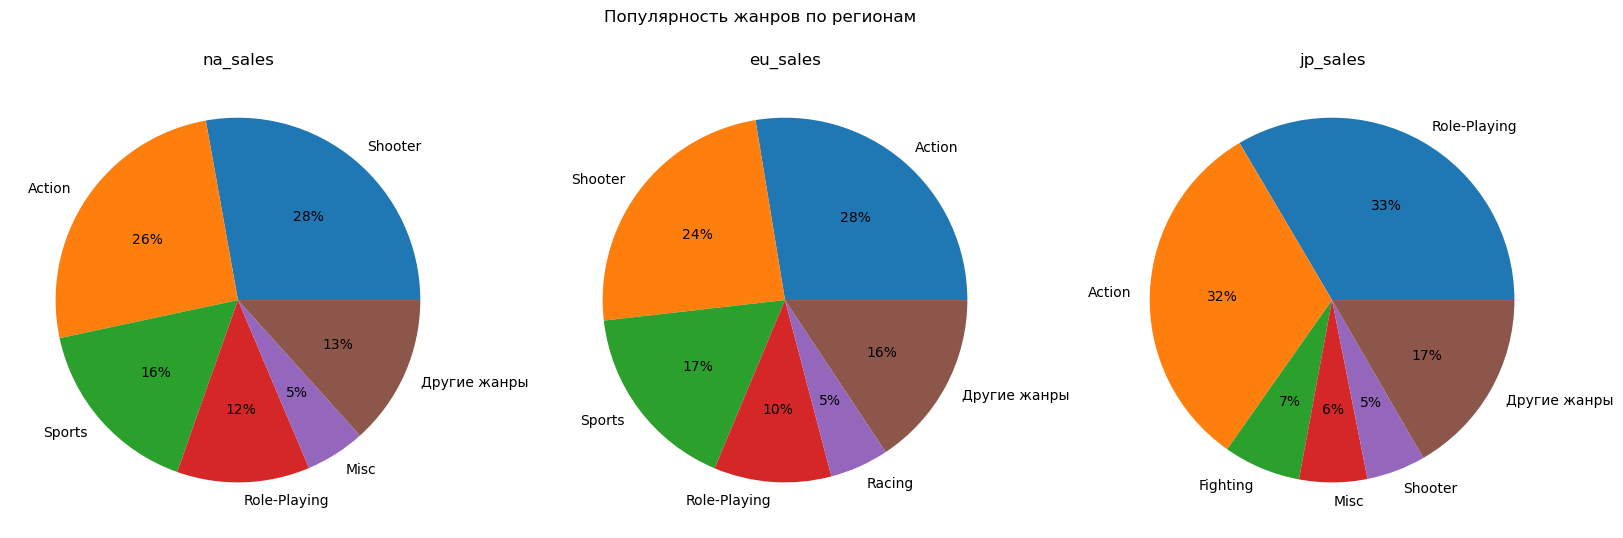

In [31]:
# Построим круговую диаграмму по жанрам для каждого региона
genre_na = (data_act.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')\
.sort_values(by = 'na_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
.sort_values(by ='na_sales', ascending = False).iloc[5:].sum()[0])
genre_na.loc[5] = ['Другие жанры', sum_p]
genre_na


genre_eu = (data_act.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')\
.sort_values(by = 'eu_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
.sort_values(by ='eu_sales', ascending = False).iloc[5:].sum()[0])
genre_eu.loc[5] = ['Другие жанры', sum_p]
genre_eu


genre_jp = (data_act.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')\
.sort_values(by = 'jp_sales', ascending = False).reset_index().loc[:4])
sum_p = (data_act.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
.sort_values(by ='jp_sales', ascending = False).iloc[5:].sum()[0])
genre_jp.loc[5] = ['Другие жанры', sum_p]
genre_jp


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6));
fig.suptitle('Популярность жанров по регионам');
ax1.pie(genre_na['na_sales'], labels=genre_na['genre'],autopct='%1.0f%%');
ax1.set_title('na_sales');
ax2.pie(genre_eu['eu_sales'], labels=genre_eu['genre'],autopct='%1.0f%%');
ax2.set_title('eu_sales');
ax3.pie(genre_jp['jp_sales'], labels=genre_jp['genre'],autopct='%1.0f%%');
ax3.set_title('jp_sales');

**Вывод**
<dd>Северная Америка и Европа в предпочтениях по жанрам практически идентичны, самые популярные жанры Action и Shooter, в Японии на первом месте жанр Role-Playung. Могу предположить, что предпочтения зависят от культуры и места проживания.

**Влияние рейтинга ESRB на продажи**

In [32]:
# Посчитаем сумму оценок рейтингов для каждого региона 
data_act.pivot_table(index='rating', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95
unknown,58.95,56.90,64.72


<dd>E (Everyone) — Для всех<dd>
<dd>E10+ (Everyone 10 and older) — Для всех от 10 лет и старше<dd>    
<dd>EC (Early childhood) — Для детей младшего возраста<dd>
<dd>M (Mature) — Для взрослых<dd>
<dd>RP (Rating Pending) — Рейтинг ожидается<dd>
<dd>T (Teen) — Подросткам<dd>  

**Вывод**

Несомненно, рейтинг влияет на продажи, можно видеть, что во всех регионах наибольшей популярностью пользуются игры для взрослых и игры для всех. В каждом регионе свои предпочтения, если в Америке и Европе больше популярны игры для взрослых, то в Японии большее предпочтение отдают играм для подростков. 

Пропуски в рейтинге ESRB, которые заменили на unknown, выявили, что данные игры практически идентично популярны во всех регионах и если бы мы не постовали заглушку, то значительная доля данных не была бы учтена, общая картина выглядела бы иначе.
        
Исходя из исследования, можно описать портрет пользователя по регионам в таком виде:

в Северной Америке это пользователь, который предпочитает платформу PS4 или XOne, игры в жанре Shooter или Action, категории М или Е.  
в Европе это пользователь, который предпочитает платформу PS4 или XOne, игры в жанре Action или Shooter, категории М или Е.  
в Японии это пользователь, который предпочитает платформу 3DS или PS4, игры в жанре Role-Playing или Action, категории Е или Т.
  

### Проверяем гипотезы

**1 гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [34]:
# Посчитаем средний пользовательский рейтинг платформ Xbox One и PC
XOne = data_act[(data_act['platform'] == 'XOne') &  (data_act['user_score'] > 0)]['user_score']
PC = data_act[(data_act['platform'] == 'PC') &  (data_act['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', XOne.mean())
print('Средний пользовательский рейтинг платформы PC', PC.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.594545454545453
Средний пользовательский рейтинг платформы PC 6.298360655737703


In [35]:
# Проверяем гипотезы
alpha = .05
results = st.ttest_ind(XOne, PC, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


**2 гипотеза:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые

H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [36]:
# Посчитаем средний пользовательский рейтинг жанров Action и Sports
Action = data_act[(data_act['genre'] == 'Action') &  (data_act['user_score'] > 0)]['user_score']
Sports = data_act[(data_act['genre'] == 'Sports') &  (data_act['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.760606060606054
Средний пользовательский рейтинг жанра Sports 5.225196850393697


In [37]:
# Проверяем гипотезы
alpha = .05
results = st.ttest_ind(Action, Sports, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Вывод**

1 гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - подтвердилась. Это означает, что пользователи ставят примерно одинаковые оценки играм на плаформах Xbox One и PC.

2 гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные - подтвердилась. Это означает, что пользователи ставят разные оценки играм с жанрами Action и Sports.

Задача стояла, потвердить или опровергнуть гипотезу, т.е. либо оценки равны, либо нет. Вопрос о том, что нужно проверить какие оценки больше, а какие меньше, не было. Был применен t-критерий, т.к. нам нужно было проверить равенства средних значений.

### Общий вывод

Закономерности определяющие успешность игры:

1. Платформа - потенциально прибыльные PS4, XOne. 
2. Жанр - самые прибыльные жанры Platform, Sports, Shooter.
3. Оценка критиков - влияет на продажи, но слабо.
4. Рейтингу ESRB - самые популярные: M(Mature) — Для взрослых, E(Everyone) — Для всех, T(Teen) — Подросткам
5. Регион - в каждом регионе свои предпочтения по платформе, жанру, и рейтингу ESRB:
<dd>-в Северной Америке предпочитают платформу PS4 или XOne, игры в жанре Shooter или Action, категории М или Е.  
<dd>-в Европе предпочитают платформу PS4 или XOne, игры в жанре Action или Shooter, категории М или Е.
<dd>-в Японии предпочитают платформу 3DS или PS4, игры в жанре Role-Playing или Action, категории Е или Т.